### Titanic - Machine Learning from Disaster

https://www.kaggle.com/competitions/titanic/data

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import BCELoss
import torch.optim as optim

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer

In [139]:
print('Check GPU runtime type... ')
use_cuda = torch.cuda.is_available()
use_cuda=False
if not use_cuda:
    device = "cpu"
    print('Change Runtype Type in top menu for GPU acceleration')
else:
    device = "cuda"
    print('OK!')

Check GPU runtime type... 
Change Runtype Type in top menu for GPU acceleration


In [140]:
trainData = pd.read_csv("Data/train.csv")
testData = pd.read_csv("Data/test.csv")
len(trainData), len(testData)

(891, 418)

In [141]:
trainData.value_counts("Survived")

Survived
0    549
1    342
dtype: int64

In [142]:
# Join both datasets in order to perform preprocessing
trainData["is_train"] = 1
testData["is_train"] = 0

data = trainData.append(testData, ignore_index=True); data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


#### Dropping Useless variables

In [143]:
data = data.drop("Name", axis=1)

#### Treat the rows with na/null values:

In [144]:
print(data.isna().sum())

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
is_train          0
dtype: int64


In [145]:
# NA values for "Age"
print("Age 'NA/Total' rate: ", data["Age"].isna().sum() / len(data))

Age 'NA/Total' rate:  0.20091673032849502


In [146]:
data["Age"] = data["Age"].fillna(data["Age"].mean())

In [147]:
print("Cabin 'NA/Total' rate: ", data["Cabin"].isna().sum() / len(data))

Cabin 'NA/Total' rate:  0.774637127578304


In [148]:
# Since most of the values for "Cabin" are unknown, we can omit this column
data = data.drop("Cabin", axis=1)

In [149]:
# Fullfilling Fare values with mean
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())

In [150]:
# Since the unknown "Embarked" values are from the test set, we can't its rows. Instead, we fulfill them with the most
#  common class
data["Embarked"] = data["Embarked"].replace(to_replace=np.nan,
                         value=data["Embarked"].value_counts(sort=True).index[0]);

####  Encode categorical attributes

In [151]:
# Dropping Ticket column (categorical but with mostly unique values)
data = data.drop("Ticket", axis=1);

In [152]:
# Label Binarizer for Ticket the 3 different ticket types
labBin = LabelBinarizer()
embarked_lab = pd.DataFrame(labBin.fit_transform(data["Embarked"]),
                           columns = ["Port_of_" + i for i in labBin.classes_],
                           index=data.index)
data = data.join(embarked_lab).drop("Embarked", axis=1)

In [153]:
# Binarizing the genre attribute
data["Sex"] = data["Sex"].replace("male", 0)
data["Sex"] = data["Sex"].replace("female", 1)

#### Split dataset, create DataLoaders

In [154]:
trainData = data[data["is_train"] == 1].drop("is_train", axis=1)

trainData, valData, trainTarget, valTarget = train_test_split(
                                                    trainData.drop("Survived", axis=1),
                                                    trainData["Survived"],
                                                    test_size=0.2)

# Data for the Kaggle predictions submission
testData = data[data["is_train"] == 0].drop(["is_train", "Survived"], axis=1)

In [155]:
class titanicDS(Dataset):
    
    def __init__(self, X, Y=None):
        if (type(Y) == type(None)):
            # We don't know the ground truth. We have to provide an 
            # empty vector instead (It will not be used)
            self.targets = torch.tensor(np.zeros(len(X)))
        else:
            self.targets = torch.tensor(Y.tolist())
        self.data = torch.tensor(X.values)
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [156]:
trainDataset = titanicDS(trainData, trainTarget)
valDataset = titanicDS(valData, valTarget)
testDataset = titanicDS(testData)

train_kwargs = {'batch_size': 64}
val_kwargs = {'batch_size': 32}
test_kwargs  = {'batch_size': 64}

if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    val_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

trainLoader = DataLoader(trainDataset, **train_kwargs)
valLoader = DataLoader(valDataset, **val_kwargs)
testLoader = DataLoader(testDataset, **test_kwargs)

#### The model

In [157]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
        
    def forward(self, x):
        output = torch.sigmoid(self.linear(x.float()))
        return output

In [190]:
# Train fase

def train(model, device, loader, criterion, optimizer, epoch, scheduler=None, progress_freq=1):
    model.train() #Train mode
    
    train_loss = []
    train_acc = []
    for batch_idx, batch in enumerate(loader):
        data, target = batch
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output.flatten(), target)
        train_loss.append(loss.detach().cpu())
        loss.backward() #Backpropagate error
        
        pred = torch.tensor([1 if  i > 0.5 else 0 for i in output])                                                     
        correct = pred.eq(target.view_as(pred)).sum().item()
        acc = 100. * correct / loader.batch_size
        train_acc.append(acc)
        
        optimizer.step()
        
        if batch_idx % progress_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item(),
                correct, len(loader.dataset), acc))
            
        if scheduler is not None:
            scheduler.step()
            
    return train_loss, train_acc

In [191]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(model, loader, criterion):
    model.eval()
    
    val_loss = 0
    correct = 0
    for batch_idx, batch in enumerate(loader):
        data, target = batch
        data, target = data.to(device), target.to(device)

        output = model(data).flatten()
        
        loss = criterion(output, target)
        val_loss += loss.item()        
        
        pred = torch.tensor([1 if  i > 0.5 else 0 for i in output])                                                     
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss

In [192]:
input_dim = trainData.shape[1]
epochs = 100

# Create the model
model = LogisticRegressionModel(input_dim)

# Adam optimizer as a first guess (adaptative gradient)
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

# Loss function-Binary Cross Entropy
criterion = BCELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(trainLoader))

losses = {"train": [], "val": []}
train_accuracies = []
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, trainLoader, criterion, optimizer, epoch, scheduler, progress_freq=2)
    losses["train"].append(np.mean(train_loss)) 
    train_accuracies.append(np.mean(train_acc))
    
    epoch_loss = validate(model, valLoader, criterion)
    losses["val"].append(epoch_loss)

Train Epoch: 1 [0/712 (0%)]	Loss: 44.189743 Accuracy: 20/712 (31%)
Train Epoch: 1 [128/712 (17%)]	Loss: 41.444153 Accuracy: 22/712 (34%)
Train Epoch: 1 [256/712 (33%)]	Loss: 55.268925 Accuracy: 15/712 (23%)
Train Epoch: 1 [384/712 (50%)]	Loss: 37.844337 Accuracy: 28/712 (44%)
Train Epoch: 1 [512/712 (67%)]	Loss: 46.062454 Accuracy: 19/712 (30%)
Train Epoch: 1 [640/712 (83%)]	Loss: 40.743027 Accuracy: 26/712 (41%)

Test set: Average loss: 1.2599, Accuracy: 70/179 (39%)

Train Epoch: 2 [0/712 (0%)]	Loss: 42.727795 Accuracy: 20/712 (31%)
Train Epoch: 2 [128/712 (17%)]	Loss: 39.956261 Accuracy: 22/712 (34%)
Train Epoch: 2 [256/712 (33%)]	Loss: 51.118324 Accuracy: 15/712 (23%)
Train Epoch: 2 [384/712 (50%)]	Loss: 36.474014 Accuracy: 28/712 (44%)
Train Epoch: 2 [512/712 (67%)]	Loss: 45.916843 Accuracy: 19/712 (30%)
Train Epoch: 2 [640/712 (83%)]	Loss: 36.815010 Accuracy: 27/712 (42%)

Test set: Average loss: 1.2126, Accuracy: 70/179 (39%)

Train Epoch: 3 [0/712 (0%)]	Loss: 39.940594 Accuracy

Train Epoch: 21 [640/712 (83%)]	Loss: 0.512655 Accuracy: 50/712 (78%)

Test set: Average loss: 0.0173, Accuracy: 145/179 (81%)

Train Epoch: 22 [0/712 (0%)]	Loss: 0.503645 Accuracy: 52/712 (81%)
Train Epoch: 22 [128/712 (17%)]	Loss: 0.489080 Accuracy: 46/712 (72%)
Train Epoch: 22 [256/712 (33%)]	Loss: 0.609292 Accuracy: 42/712 (66%)
Train Epoch: 22 [384/712 (50%)]	Loss: 0.622500 Accuracy: 42/712 (66%)
Train Epoch: 22 [512/712 (67%)]	Loss: 0.474462 Accuracy: 51/712 (80%)
Train Epoch: 22 [640/712 (83%)]	Loss: 0.511994 Accuracy: 53/712 (83%)

Test set: Average loss: 0.0171, Accuracy: 143/179 (80%)

Train Epoch: 23 [0/712 (0%)]	Loss: 0.492182 Accuracy: 50/712 (78%)
Train Epoch: 23 [128/712 (17%)]	Loss: 0.485326 Accuracy: 45/712 (70%)
Train Epoch: 23 [256/712 (33%)]	Loss: 0.651108 Accuracy: 38/712 (59%)
Train Epoch: 23 [384/712 (50%)]	Loss: 0.638777 Accuracy: 40/712 (62%)
Train Epoch: 23 [512/712 (67%)]	Loss: 0.469537 Accuracy: 51/712 (80%)
Train Epoch: 23 [640/712 (83%)]	Loss: 0.518014 Acc

Train Epoch: 41 [0/712 (0%)]	Loss: 0.416852 Accuracy: 52/712 (81%)
Train Epoch: 41 [128/712 (17%)]	Loss: 0.358186 Accuracy: 59/712 (92%)
Train Epoch: 41 [256/712 (33%)]	Loss: 0.666603 Accuracy: 40/712 (62%)
Train Epoch: 41 [384/712 (50%)]	Loss: 0.672922 Accuracy: 42/712 (66%)
Train Epoch: 41 [512/712 (67%)]	Loss: 0.423921 Accuracy: 54/712 (84%)
Train Epoch: 41 [640/712 (83%)]	Loss: 0.422847 Accuracy: 55/712 (86%)

Test set: Average loss: 0.0161, Accuracy: 145/179 (81%)

Train Epoch: 42 [0/712 (0%)]	Loss: 0.415267 Accuracy: 52/712 (81%)
Train Epoch: 42 [128/712 (17%)]	Loss: 0.354835 Accuracy: 58/712 (91%)
Train Epoch: 42 [256/712 (33%)]	Loss: 0.673184 Accuracy: 40/712 (62%)
Train Epoch: 42 [384/712 (50%)]	Loss: 0.669706 Accuracy: 42/712 (66%)
Train Epoch: 42 [512/712 (67%)]	Loss: 0.419102 Accuracy: 54/712 (84%)
Train Epoch: 42 [640/712 (83%)]	Loss: 0.423811 Accuracy: 55/712 (86%)

Test set: Average loss: 0.0160, Accuracy: 145/179 (81%)

Train Epoch: 43 [0/712 (0%)]	Loss: 0.413662 Accura

Train Epoch: 63 [0/712 (0%)]	Loss: 0.399147 Accuracy: 50/712 (78%)
Train Epoch: 63 [128/712 (17%)]	Loss: 0.318131 Accuracy: 57/712 (89%)
Train Epoch: 63 [256/712 (33%)]	Loss: 0.574739 Accuracy: 47/712 (73%)
Train Epoch: 63 [384/712 (50%)]	Loss: 0.538112 Accuracy: 43/712 (67%)
Train Epoch: 63 [512/712 (67%)]	Loss: 0.410373 Accuracy: 53/712 (83%)
Train Epoch: 63 [640/712 (83%)]	Loss: 0.372851 Accuracy: 56/712 (88%)

Test set: Average loss: 0.0149, Accuracy: 149/179 (83%)

Train Epoch: 64 [0/712 (0%)]	Loss: 0.398002 Accuracy: 50/712 (78%)
Train Epoch: 64 [128/712 (17%)]	Loss: 0.317451 Accuracy: 57/712 (89%)
Train Epoch: 64 [256/712 (33%)]	Loss: 0.574534 Accuracy: 47/712 (73%)
Train Epoch: 64 [384/712 (50%)]	Loss: 0.537985 Accuracy: 43/712 (67%)
Train Epoch: 64 [512/712 (67%)]	Loss: 0.410832 Accuracy: 53/712 (83%)
Train Epoch: 64 [640/712 (83%)]	Loss: 0.372253 Accuracy: 56/712 (88%)

Test set: Average loss: 0.0149, Accuracy: 149/179 (83%)

Train Epoch: 65 [0/712 (0%)]	Loss: 0.397027 Accura

Train Epoch: 83 [256/712 (33%)]	Loss: 0.579169 Accuracy: 47/712 (73%)
Train Epoch: 83 [384/712 (50%)]	Loss: 0.542898 Accuracy: 45/712 (70%)
Train Epoch: 83 [512/712 (67%)]	Loss: 0.399388 Accuracy: 53/712 (83%)
Train Epoch: 83 [640/712 (83%)]	Loss: 0.370943 Accuracy: 57/712 (89%)

Test set: Average loss: 0.0149, Accuracy: 149/179 (83%)

Train Epoch: 84 [0/712 (0%)]	Loss: 0.392248 Accuracy: 49/712 (77%)
Train Epoch: 84 [128/712 (17%)]	Loss: 0.317959 Accuracy: 58/712 (91%)
Train Epoch: 84 [256/712 (33%)]	Loss: 0.579327 Accuracy: 47/712 (73%)
Train Epoch: 84 [384/712 (50%)]	Loss: 0.541499 Accuracy: 45/712 (70%)
Train Epoch: 84 [512/712 (67%)]	Loss: 0.399635 Accuracy: 53/712 (83%)
Train Epoch: 84 [640/712 (83%)]	Loss: 0.370570 Accuracy: 57/712 (89%)

Test set: Average loss: 0.0149, Accuracy: 149/179 (83%)

Train Epoch: 85 [0/712 (0%)]	Loss: 0.392090 Accuracy: 49/712 (77%)
Train Epoch: 85 [128/712 (17%)]	Loss: 0.317525 Accuracy: 58/712 (91%)
Train Epoch: 85 [256/712 (33%)]	Loss: 0.578993 Acc

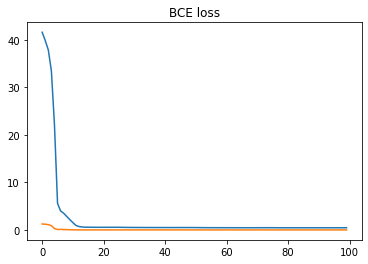

In [193]:
plt.plot(np.arange(len(losses["train"])), losses["train"],
         np.arange(len(losses["val"])), losses["val"])
plt.title('BCE loss')
plt.show()

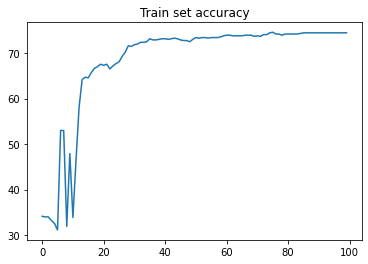

In [194]:
plt.plot(np.arange(len(train_accuracies)), train_accuracies)
plt.title('Train set accuracy')
plt.show()